In [3]:
# Import IBIS
import sys
sys.path.append('/Users/jackcarter/Documents/IBIS Code Folder/')
from ibis_codes_2025 import IBIS_Main

In [4]:
test = IBIS_Main.IBIS('/Users/jackcarter/Documents/Initial_Thorium/Schorndorf_2023_IBIS_Input.xlsx',
    sample_name='Schorndorf2023',          
    MCMC_samples=600000,
    MCMC_burn_in=100000,
    MCMC_Strat_samples=500000,
    n_chains=3,
    Start_from_pickles=True, 
    show_bird=False, 
    method='thoth'
)


Data loaded successfully from /Users/jackcarter/Documents/Initial_Thorium/Schorndorf_2023_IBIS_Input.xlsx (Excel)


In [8]:
test.Set_Up_MCMC();

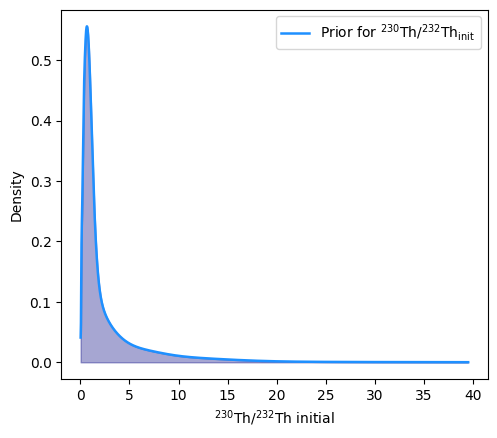

In [9]:
test.Plot_Priors(); 

In [11]:
test.Run_MCMC()

Loaded starting θ from pickles


In [12]:
inThor, inThor_err = test.Model_Initial_Thorium()

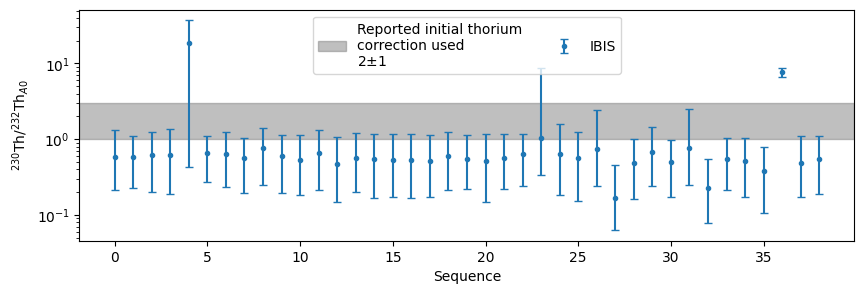

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1, figsize= (10, 3))
ax.errorbar(x = np.arange(inThor.size), 
            y = inThor, 
            yerr = inThor_err, fmt = 'o', 
            capsize = 3, markersize = 3, 
           label = 'IBIS')

ax.axhspan(1, 3, label = 'Reported initial thorium\ncorrection used\n2$\pm$1', 
          color = 'grey', alpha = 0.5)

ax.set_yscale('log')
ax.set_ylabel('$^{230}$Th/$^{232}$Th$_{A0}$')
ax.set_xlabel('Sequence')
ax.legend(ncol = 2)

In [6]:
test.SaveSummary()

Summary saved to Schorndorf2023_ibis_summary.csv


In [7]:
test.Save_All()

Initial thorium model data saved to Schorndorf2023_Initial_Thoriums.xlsx
Useries age model data saved to Schorndorf2023_U_Series_Ages.xlsx
Initial 234U saved to Schorndorf2023_Initial_234U.xlsx


In [8]:
test.Run_MCMC_Strat()

File 'Schorndorf2023_U_Series_Ages.xlsx' exists. Skipping initial MCMC and running stratigraphy MCMC directly. Sit Tight. Time for a cup of tea.
Starting from linear-fit guesses


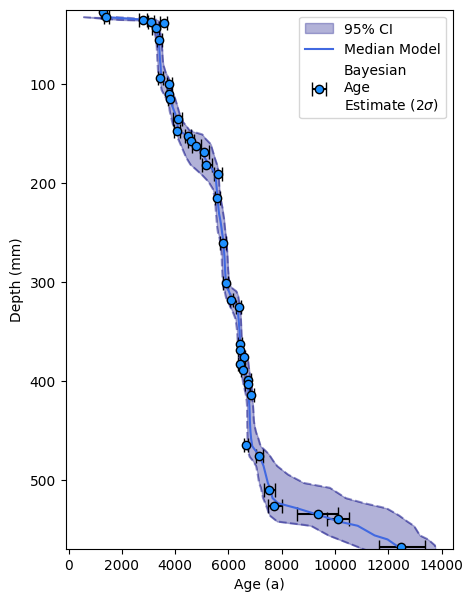

In [9]:
test.Get_Age_Depth_Plot()

In [10]:
test.Save_Age_Depth_Model()

Age/Depth model saved to: Schorndorf2023_Age_Depth_Model.xlsx


In [11]:
# IBIS Proxy class
import IBIS_Proxy

In [25]:
import pandas as pd
# Read in the 
df_age = pd.read_excel('Schorndorf2023_U_Series_Ages.xlsx')
df_inT = pd.read_excel('Schorndorf2023_Initial_Thoriums.xlsx')
df_inU = pd.read_excel('Schorndorf2023_Initial_234U.xlsx')

df_agedepth = pd.read_csv('Schorndorf2023_Age_Depth_Model.csv')

In [26]:
def MakePlottingDataFrame(df_age, df_inTh, df_inU): 

    df = pd.DataFrame({"Age": df_age['U_ages'].values, 
                      "Age_low": df_age['U_Age_low'].values, 
                      "Age_high": df_age['U_Age_high'].values, 
                       "Initial Th230": df_inTh['Model_initial_th'].values, 
                      "Initial Th230 low": df_inTh['M_Initial_Thorium_err1'].values, 
                      "Initial Th230 high": df_inTh['M_Initial_Thorium_err2'].values, 
                      "Initial U234": df_inU['Model_initial_234U'].values, 
                      "Initial U234 low": df_inU['Model_initial_234U_err1'].values, 
                      "Initial U234 high": df_inU['Model_initial_234U_err2'].values, 
                      "Depth": df_age['Depth_Meas'].values})

    return df

In [27]:
df_all = MakePlottingDataFrame(df_age, df_inT, df_inU)

In [31]:
# Add fine scale proxy - rolling correlation test
test = IBIS_Proxy.IbisProxy(df_all, df_agedepth)

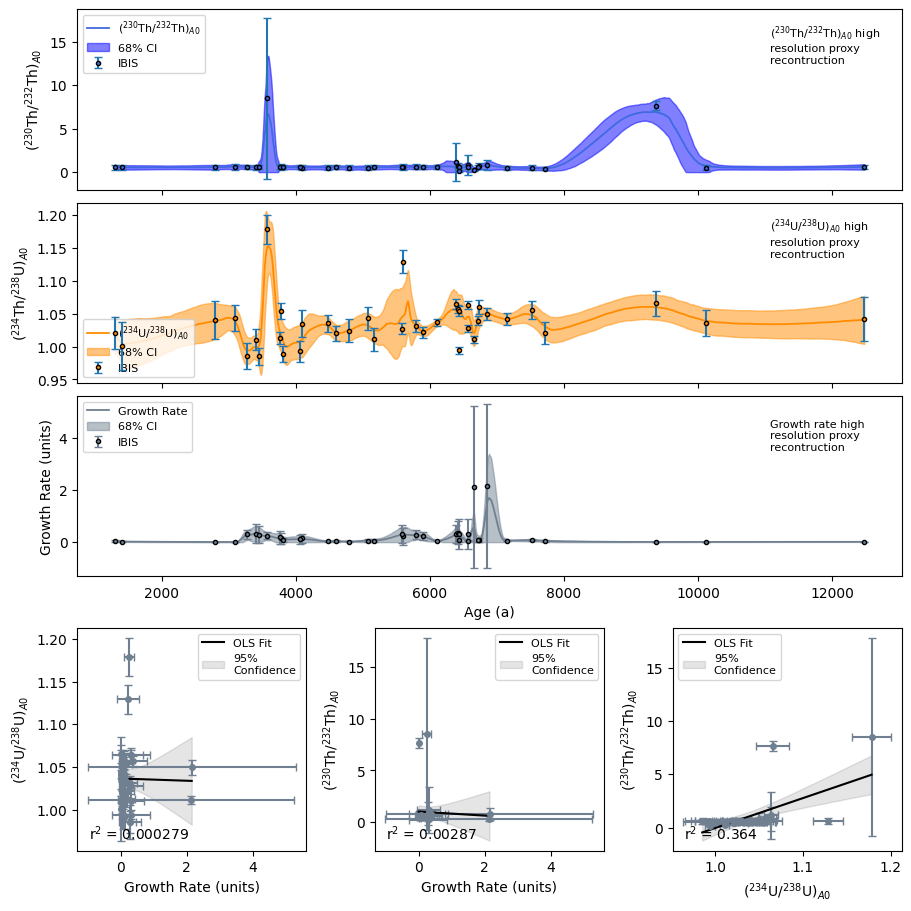

In [32]:
test.Proxy_Plot_All(save = False)

In [24]:
import pandas as pd
df_geochem_schorndorf = pd.read_excel('Schorndorf_Geochem/Schorndorf_Geochem.xlsx')

In [28]:
df_summary = pd.read_csv('Schorndorf2023_ibis_summary.csv')

In [30]:
def Z_score_Standardize(val, err=None, *, mu_err=0.0, sd_err=0.0, ddof=1):
    """
    Z-score standardize function

    """
    val = np.asarray(val, dtype=float)
    # compute reference stats from the data
    mu = float(np.nanmean(val))
    sd = float(np.nanstd(val, ddof=ddof))
    sd_safe = np.clip(sd, 1e-12, np.inf)

    z = (val - mu) / sd_safe

    # If no uncertainties supplied at all, return None for z_err
    no_val_err = (err is None)
    if no_val_err and (mu_err == 0.0) and (sd_err == 0.0):
        z_err = None
        return z, z_err, mu, sd

    # Otherwise propagate: σ_z^2 = (σ_x/sd)^2 + (σ_mu/sd)^2 + ((z*σ_sd)/sd)^2
    if err is None:
        err = 0.0
    err = np.asarray(err, dtype=float)

    z_err = np.sqrt((err / sd_safe)**2 +
                    (mu_err / sd_safe)**2 +
                    ((z * sd_err) / sd_safe)**2)

    return z, z_err 

In [66]:
Z_mg = Z_score_Standardize(df_geochem_schorndorf['Mg/Ca'].values, err = None)
Z_ba = Z_score_Standardize(df_geochem_schorndorf['Ba/Ca'].values, err = None)
Z_fe = Z_score_Standardize(df_geochem_schorndorf['Fe/Ca'].values, err = None)
Z_mn = Z_score_Standardize(df_geochem_schorndorf['Mn/Ca'].values, err = None)
Z_s = Z_score_Standardize(df_geochem_schorndorf['S/Ca'].values, err = None)
Z_sr = Z_score_Standardize(df_geochem_schorndorf['Sr/Ca'].values, err = None)
Z_d13c = Z_score_Standardize(df_geochem_schorndorf['delta_13C'].values, err = None)
Z_d18o = Z_score_Standardize(df_geochem_schorndorf['delta_18O'].values, err = None)
Z_thor =  Z_score_Standardize(df_summary['initial thorium'].values, err =df_summary['initial thorium err'].values)
Z_uran =  Z_score_Standardize(df_summary['initial uranium'].values, err =df_summary['initial uranium err'].values)

In [67]:
Z_scores = [Z_mg, Z_ba, Z_fe, Z_mn, Z_s, Z_sr, Z_d13c, Z_d18o, Z_thor, Z_uran]

In [68]:
labels = ['Mg/Ca', 'Ba/Ca', 'Fe/Ca', 'Mn/Ca', 'S/Ca', 'Sr/Ca',
          '$\delta^{13}$C', '$\delta^{18}$O', '$^{230}$Th/$^{232}$Th$_{A0}$', 
         '$^{234}$U/$^{238}$U$_{A0}$']

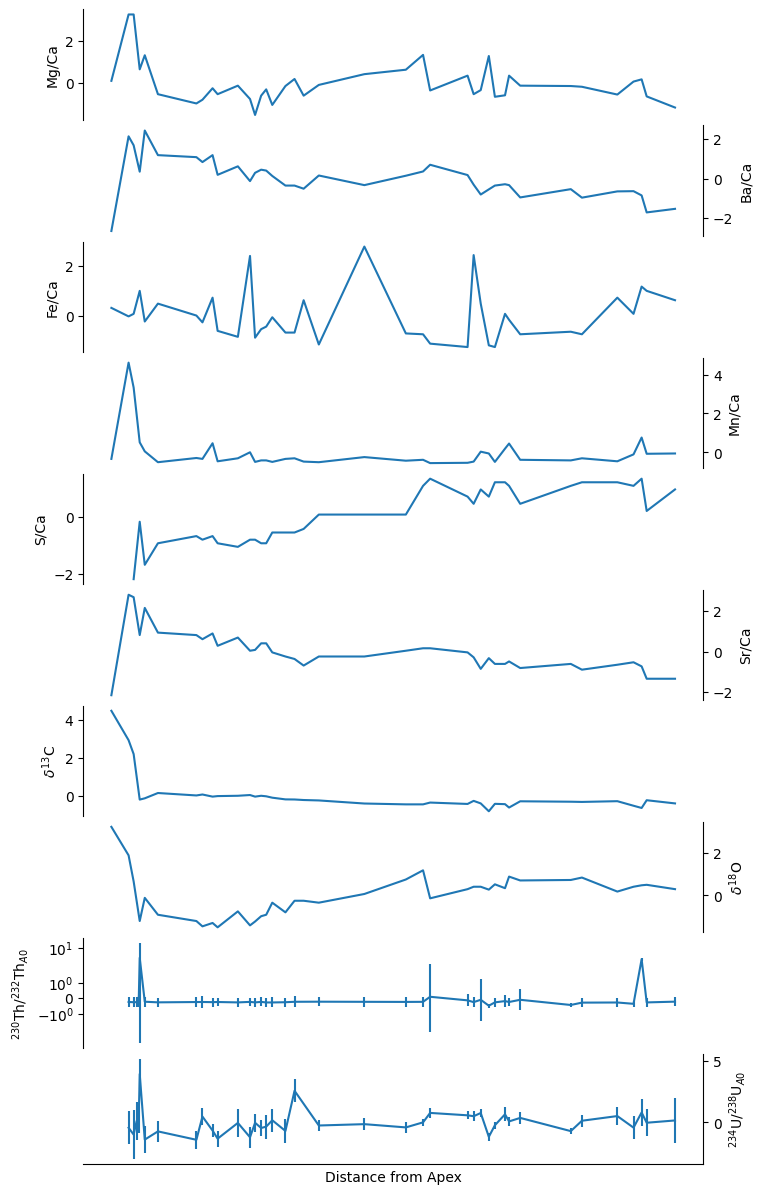

In [69]:
fig, ax = plt.subplots(10, 1, figsize=(8, 15), sharex=True)
axes = np.atleast_1d(ax)  # ensure array

for i, ax_ in enumerate(axes):
    # ---- your plotting ----
    if i <= 7:
        ax_.plot(
            df_geochem_schorndorf['Distance from apex'].values,
            Z_scores[i][0]
        )
    else:  # i >= 8
        ax_.errorbar(
            x=df_summary['Depth_Meas'].values,
            y=Z_scores[i][0],
            yerr=Z_scores[i][1]
        )
    if i ==8: 
        ax_.set_yscale('symlog')

    # ---- alternate y-axis sides ----
    if i % 2 == 0:
        ax_.yaxis.set_label_position('left')
        ax_.yaxis.tick_left()
        ax_.spines['left'].set_visible(True)
        ax_.spines['right'].set_visible(False)
    else:
        ax_.yaxis.set_label_position('right')
        ax_.yaxis.tick_right()
        ax_.spines['left'].set_visible(False)
        ax_.spines['right'].set_visible(True)

    ax_.set_ylabel(labels[i])

    # ---- remove x-spines except bottom ----
    ax_.spines['top'].set_visible(False)  # always hide top
    if i < len(axes) - 1:
        ax_.spines['bottom'].set_visible(False)
        ax_.tick_params(axis='x', which='both', labelbottom=False)
        ax_.set_xticks([])
    else:
        ax_.spines['bottom'].set_visible(True)
        ax_.tick_params(axis='x', which='both', labelbottom=True)
        ax_.set_xlabel('Distance from Apex')
# squeeze panels closer together
fig.subplots_adjust(hspace=0.05)